In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
import torchvision 
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters Section 

In [2]:
batch_size = 1
input_dims = 100
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data and Dataloader preparing section

In [3]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((128  , 128)),
    transforms.ToTensor(),
    ])
dataset = torchvision.datasets.ImageFolder("./dataset/animals" ,transform=TRANSFORM_IMG)

dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True, num_workers=4)


# Model definition

In [4]:
class Generator(nn.Module):
    def __init__(self , input_dims):
        super(Generator, self).__init__()

        self.input_dims = input_dims
        self.input_layer = nn.Linear(input_dims , 4*4*1024)
        self.conv1T = nn.ConvTranspose2d(1024 , 512 , kernel_size=(5,5) , stride=2 , padding=2, output_padding=1 )
        self.conv2T = nn.ConvTranspose2d(512, 256 , kernel_size=(5,5)  ,stride=2 , padding=2 , output_padding=1)
        self.conv3T = nn.ConvTranspose2d(256 , 128 , kernel_size=(5,5) ,stride=2 , padding=2, output_padding=1)
        self.conv4T = nn.ConvTranspose2d( 128 , 64 , kernel_size=(5,5) ,stride=2 , padding=2 , output_padding=1)
        self.conv5T = nn.ConvTranspose2d( 64 , 3 , kernel_size=(5,5) ,stride=2 , padding=2 , output_padding=1)

    def forward(self ,z):
        z = self.input_layer(z)
        z = z.view(-1 , 1024 , 4 , 4)
        z = torch.nn.functional.relu(self.conv1T(z))
        z = torch.nn.functional.relu(self.conv2T(z))
        z = torch.nn.functional.relu(self.conv3T(z))
        z = torch.nn.functional.relu(self.conv4T(z))
        z = torch.nn.functional.tanh(self.conv5T(z))
        return z


class Critic(nn.Module):
    def __init__(self,output_dims):
        super(Critic,self).__init__()
        self.conv5 = nn.ConvTranspose2d( 3 , 64 , kernel_size=(5,5) ,stride=2 , padding=2 )
        self.conv4 = nn.ConvTranspose2d( 64 , 128 , kernel_size=(5,5) ,stride=2 , padding=2 )
        self.conv3 = nn.ConvTranspose2d(128 , 256 , kernel_size=(5,5) ,stride=2 , padding=2)
        self.conv2 = nn.ConvTranspose2d(256, 512 , kernel_size=(5,5)  ,stride=2 , padding=2 )
        self.conv1 = nn.ConvTranspose2d(512 , 1024 , kernel_size=(5,5) , stride=2 , padding=2 )
        self.output_layer = nn.Linear(4*4*1024, output_dims)
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.conv5(x))
        x = torch.nn.functional.leaky_relu(self.conv4(x))
        x = torch.nn.functional.leaky_relu(self.conv3(x))
        x = torch.nn.functional.leaky_relu(self.conv2(x))
        x = torch.nn.functional.leaky_relu(self.conv1(x))
        x = x.view(-1 , 4*4*1024)
        return torch.nn.functional.sigmoid(self.output_layer(x))
    

class DCGan(nn.Module):
    def __init__(self,input_dims =100, output_dims = 1):
        super(DCGan,self).__init__()
        self.gen = Generator(input_dims)
        self.critic = Critic(output_dims)
    def forward(self , latents , images):
        x = self.gen(latents)
        real = self.critic(images) 
        generated = self.critic(x)
        return real , generated
        




In [5]:
class DCTrainer():
    def __init__(self,model , dataloader , optim_gen , optim_critic  , epochs, device ,latent_dims, ngenerate = 5):
        self.model = model.to(device)
        self.dataloader = dataloader
        self.optim_gen = optim_gen 
        self.optim_critc = optim_critic
        self.epochs = epochs
        self.device = device
        self.ngenerate = ngenerate
        self.latent_dims = latent_dims
        self.mvn = torch.distributions.MultivariateNormal( torch.zeros(latent_dims)  , torch.eye(latent_dims) )
    
    
    def latent_sampler(self ,batch_size ):
        samples = self.mvn.sample((batch_size,))
        return samples
    
    def loss_W2(real_y, gen_y,):
        t1 = real_y.squeeze(0).mean(0)
        t2 = gen_y.squeeze(0).mean(0)
        return (t2-t1) , -t2
    
    def train_step(self) :
        total_loss_critic = 0
        total_loss_gen = 0
        for data , _ in self.dataloader:
            z = self.latent_sampler(data.shape[0]).to(device=self.device)
            real_y , gen_y   = self.model(z , data.to(self.device)) 
            self.optim_gen.zero_grad()
            self.optim_critc.zero_grad()
            loss_critic , loss_gen = self.loss_W2(real_y , gen_y)
            loss = loss_gen + loss_critic
            loss.backward()
            self.optim_critc.step()
            self.optim_gen.step()
            total_loss_critic += loss_critic.item()
            total_loss_gen += loss_gen.item()
        return total_loss_critic/len(self.dataloader) , total_loss_gen/len(self.dataloader)

    def generate_images(self):
        self.model.eval()
        with torch.no_grad():
            z = self.latent_sampler(self.ngenerate).to(device=self.device)
            images = self.model.gen(z)
            return images
        
    def train(self):
        for epoch in range(self.epochs):
            loss_critic , loss_gen = self.train_step()
            print(f"Epoch {epoch} Generator Loss {loss_gen} Critic loss {loss_critic}")




# Instantiation

In [6]:

model = DCGan(input_dims , output_dims=1).to(device=device)


optim_critc = torch.optim.Adam(model.critic.parameters())
optim_gen = torch.optim.Adam(model.gen.parameters())

trainer = DCTrainer(model , dataloader , optim_critic=optim_critc, optim_gen=optim_gen , epochs=epochs , device = device , latent_dims=input_dims )

In [14]:
sum([x.numel() for x in model.parameters()]) 

36499716

In [7]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.88 GiB. GPU 0 has a total capacity of 10.75 GiB of which 259.56 MiB is free. Including non-PyTorch memory, this process has 10.49 GiB memory in use. Of the allocated memory 10.28 GiB is allocated by PyTorch, and 24.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [271]:
image[0].shape

torch.Size([3, 128, 128])

In [272]:
image  = image[0].permute(1,2,0).detach().cpu().numpy()

In [273]:
image.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12284384..0.12854812].


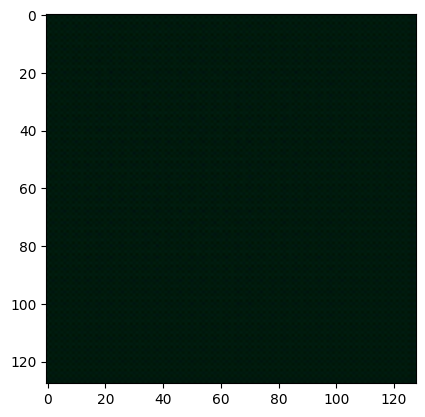

In [274]:
plt.imshow(image)
plt.axis('on')  # Hide axis ticks and labels
plt.show()

In [203]:
image[0,:,0]

array([-0.73918474, -0.66071856,  0.99865603, -0.28824896,  0.880924  ,
        0.3841806 ,  0.7614908 , -0.3208044 , -0.9959201 , -0.91391474,
        0.61241645,  0.75544083,  0.14779232,  0.6397902 ,  0.5859547 ,
       -0.90147156, -0.8544219 ,  0.28436416,  0.9190668 , -0.14827691,
       -0.43643847, -0.16382952,  0.8678724 , -0.28335518,  0.93022674,
        0.4221373 ,  0.6993247 ,  0.06686836, -0.9461559 , -0.23770091,
        0.46330655, -0.20983364,  0.52943325, -0.41866627,  0.8352332 ,
        0.49988058,  0.72966003,  0.6580966 , -0.80229425, -0.44851816,
        0.34498248, -0.6729341 , -0.25607765,  0.75387216, -0.36318144,
       -0.74096835, -0.35776988, -0.9126502 , -0.61903673, -0.9708587 ,
        0.88098204,  0.9295086 , -0.61498606,  0.63178927, -0.16521467,
        0.6854446 , -0.88829184,  0.4125484 ,  0.6856741 ,  0.8125684 ,
        0.68930453, -0.06374902,  0.7387769 , -0.8090332 , -0.6712822 ,
        0.16553092,  0.84571344,  0.48066178, -0.2198517 ,  0.62